# 1. Многоклассовая классификация

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 3000
X_test /= 3000
X_train = np.hstack((X_train, np.ones((len(X_train), 1))))
X_test = np.hstack((X_test, np.ones((len(X_test), 1))))

In [11]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [12]:
class Classifier:
    def __init__(self):
        self.w = np.random.uniform(0, 1, (10, 785))
        
    def gradient(self, p, x, label):
        grad = np.dot(np.reshape(p, (10, 1)), np.array([x]))
        grad[label] -= x
        return grad

    def learn(self, x, y):
        for i in range(len(y)):
            p = softmax(np.dot(self.w, x[i]))
            self.w -= self.gradient(p, x[i], y[i])

    def classify(self, x):
        p = softmax(np.dot(self.w, x))
        return np.argmax(p)

    def measure_accuracy(self, X_test, y_test):
        cnt = 0.
        for i in range(len(X_test)):
            answer = self.classify(X_test[i])
            if answer == y_test[i]:
                cnt += 1
        return cnt / len(X_test)

In [16]:
cl = Classifier()
cl.learn(X_train, y_train)
print(cl.measure_accuracy(X_test, y_test))

0.9096


 ## Регуляризация

In [23]:
k1, k2 = 1e-7, 1e-8

class Classifier2(Classifier):
    def gradient(self, p, x, label):
        grad = np.dot(np.reshape(p, (10, 1)), np.array([x]))
        grad[label] -= x
        grad += np.sign(self.w) * k1 + k2 * self.w
        return grad

In [24]:
cl = Classifier2()
cl.learn(X_train, y_train)
print(cl.measure_accuracy(X_test, y_test))

0.9096


#### Если коэффециенты достаточно большие, чтобы влиять на точность, она ухудшается, а при слишком маленьких увеличивается незначительно

# 2. Полносвязные нейронные сети

#### 1. Предложить w и b, чтобы $y=\theta(wx+b)$ реализовывала следующие операторы:
$$1.\ wx + b = x_1\wedge x_2$$
$$2.\ wx + b = x_1\vee x_2$$
$$3.\ wx + b = \overline{x_1}\wedge \overline{x_2}$$
#### Решение

$$1.\ w = (1,1),\ b = -1.5$$

$$2.\ w = (1,1),\ b = -0.5$$

$$2.\ w = (-1,-1),\ b = 0.5$$

#### 2. Пример нереализуемой функции:
$$y = x_1 \equiv x_2$$


#### 3. Найти предствление через 

$$f(x)=\theta(W_2\theta(W_1x+b_1) + b_2)$$

#### Решение
$$y = (x_1 \wedge x_2) \vee (\overline{x_1}\wedge \overline{x_2})$$

$$W_1 = \begin{pmatrix}
1 & 1 \\
-1 & -1 \\
\end{pmatrix}$$

$$b_1=\begin{pmatrix}
-1.5 \\
0.5
\end{pmatrix}$$

$$W_2=(1,1),\ b_2=-0.5$$

Первый элемент вектора $\theta(W_1x+b_1)$ - значение левой скобки, второй - правой.

Оператор $\theta(W_2x+b)$ - дизъюнкция этих скобок.

#### 4. Представление произвольной булевой функции

Любая булева функция может быть представлена в ДНФ с помощью таблицы истинности. Остается реализовать конъюнкции.

Каждая строка матрицы $W_{1i}$ будет отвечать за $i$-ю скобку. В ней стоят единицы для литералов, которые взяты в скобке без отрицания, -1 для литералов с отрицанием и 0 для остальных. $b_{1i} = -k + 0.5$, где $k$ - количество литералов, взятых без отрицания. Легко проверить, что полученное значение $W_{1i}x+b_{1i}>0\ \Leftrightarrow\ $ все литералы в скобке равны 1.

Строка $W_2$ будет состоять из $n$ единиц (где $n$ - количество скобок), а $b_2=-0.5$.

Тогда $W_2x+b_2>0\ \Leftrightarrow\ \exists i:x_i=1$, то есть, $\theta(W_2x+b)$ - дизъюнкция $x_1\ldots x_n$.

# Двуслойная сеть

In [19]:

from __future__ import print_function
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils


batch_size = 128
nb_classes = 10
nb_epoch = 3

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 9s - loss: 0.2537 - acc: 0.9273 - val_loss: 0.1341 - val_acc: 0.9607
Epoch 2/3
60000/60000 [==============================] - 8s - loss: 0.1047 - acc: 0.9690 - val_loss: 0.0955 - val_acc: 0.9720
Epoch 3/3
60000/60000 [==============================] - 9s - loss: 0.0689 - acc: 0.9794 - val_loss: 0.0912 - val_acc: 0.9714
Test score: 0.0911891011957
Test accuracy: 0.9714


### Точность увеличилась с 91% до 97%

## Влияние размерности выходного вектора 1 слоя на точность

In [ ]:
sizes = []
accuracy = []

for i in range(10, 850, 30):
    sizes.append(i)
    model = Sequential()
    model.add(Dense(i, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    accuracy.append(score[1])

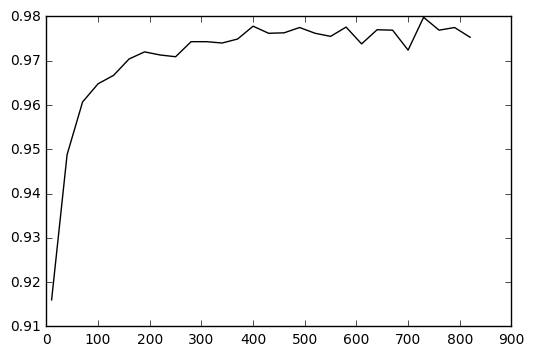

In [15]:
plt.plot(sizes, accuracy, 'k-')
plt.show()

Итого, точность максимальна, когда выходной размер равен входному, и начинает сильно падать при уменьшении размерности в более, чем 2 раза

## Влияние количества слоев на точность

In [12]:
layers_count = []
accuracy = []
nb_epoch = 5
batch_size = 256

for i in range(1, 10):
    print(i)
    layers_count.append(i)
    model = Sequential()
    for j in range(i):
        model.add(Dense(400, input_shape=(784,)))
        model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=1, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    accuracy.append(score[1])

1
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s - loss: 0.3192 - acc: 0.9103 - val_loss: 0.1771 - val_acc: 0.9464
Epoch 2/5
60000/60000 [==============================] - 5s - loss: 0.1396 - acc: 0.9592 - val_loss: 0.1289 - val_acc: 0.9615
Epoch 3/5
60000/60000 [==============================] - 5s - loss: 0.0928 - acc: 0.9729 - val_loss: 0.0869 - val_acc: 0.9737
Epoch 4/5
60000/60000 [==============================] - 5s - loss: 0.0677 - acc: 0.9803 - val_loss: 0.0813 - val_acc: 0.9749
Epoch 5/5
60000/60000 [==============================] - 5s - loss: 0.0521 - acc: 0.9843 - val_loss: 0.0796 - val_acc: 0.9752
2
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 8s - loss: 0.2851 - acc: 0.9117 - val_loss: 0.1713 - val_acc: 0.9449
Epoch 2/5
60000/60000 [==============================] - 8s - loss: 0.1006 - acc: 0.9688 - val_loss: 0.1119 - val_acc: 0.9646
Epoch 3/5
6000

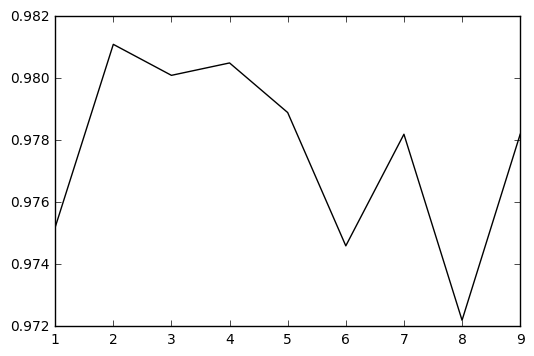

In [14]:
plt.plot(layers_count, accuracy, 'k-')
plt.show()

### Итого, при фиксированном количестве проходов по данным, максимальная точность у двуслойной сети.

# Произвольная архитектура

In [24]:
nb_epoch = 15
batch_size = 128

model = Sequential()
model.add(Dense(784, input_shape=(784,)))
model.add(Activation('tanh'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 24s - loss: 0.2644 - acc: 0.9184 - val_loss: 0.1538 - val_acc: 0.9523
Epoch 2/15
60000/60000 [==============================] - 23s - loss: 0.1086 - acc: 0.9661 - val_loss: 0.1194 - val_acc: 0.9639
Epoch 3/15
60000/60000 [==============================] - 24s - loss: 0.0741 - acc: 0.9762 - val_loss: 0.0981 - val_acc: 0.9693
Epoch 4/15
60000/60000 [==============================] - 25s - loss: 0.0553 - acc: 0.9817 - val_loss: 0.0861 - val_acc: 0.9743
Epoch 5/15
60000/60000 [==============================] - 22s - loss: 0.0428 - acc: 0.9864 - val_loss: 0.0866 - val_acc: 0.9753
Epoch 6/15
60000/60000 [==============================] - 22s - loss: 0.0344 - acc: 0.9892 - val_loss: 0.0808 - val_acc: 0.9769
Epoch 7/15
60000/60000 [==============================] - 23s - loss: 0.0271 - acc: 0.9915 - val_loss: 0.0741 - val_acc: 0.9810
Epoch 8/15
60000/60000 [==============================